# Procesamiento de Trayectorias
## Ejemplo del análisis de trayectorias

Cargamos las librerías necesarias

In [5]:
import pandas as pd
import numpy as np
import pytraj as pyt
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

In [7]:
prot_name = 'cdk2'

In [8]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS.json')))[0]
                      
df_prot = pd.read_json(path_to_json_file)

Residuos de referencia para generar los resultados.  
En este análisis, por ahora sólo usaremos los residuos de Pisani.

In [9]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")

In [10]:
mask_pisani = F"(:{pisiani_residues})&(@CA)"

# MDS de las estructuras de Referencia
<h3 class='text-danger'>Corresponde al MDS usando las 402 estructuras cristalográficas de la proteína</h3>

Para la proyección de puntos en el espacio de los cristales primero debemos obtener dicho espacio.
- Se carga la trayectoria con pytraj, únicamente los átomos de la proteína.
- Sólo para asegurarnos:
    - Se superpone la trayectoria primero con respecto al primer frame.
    - Luego se calcula la estructura promedio tras la superposición.
    - Luego se superpone toda la trayectoria a esa estructura promedio.

In [11]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = os.path.join("..", "..", "ARCHIVOS", "CRISTALES", 
                                  "TRAJ_CRISTALS_PDB", "PDB_402_cdk2_PISANI_ALL.pdb")
# Por ahora cargamos tods los átomos, sumiendo que en algun momento necesitaremos todos los átomos
traj_crystals = pyt.load(file_pdb_traj_pisani)
# Nos aseguramos de superponer la trayectoria a una estructura promedio
# NOTA: prody realiza esta optimización iterando hasta minimizar el rmsd con el método superpose
# no obstante, las pruebas hechas muestran que el impacto es mínimo 
# pues incluso omitiendo las siguientes tres líneas el mds es el msimo
traj_crystals = traj_crystals.superpose()[mask_pisani]
avg_ref_traj = pyt.mean_structure(traj_crystals)
pyt.superpose(traj_crystals, ref = avg_ref_traj)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 117.


### Cálculo de la matriz de RMSD
<div class="alert alert-block alert-danger">
    <p><b>OJO:</b> No se usa la máscara porque directamente la hemos proporcionado ya al cargar la trayectoria con los átomos seleccionados a modo de <i>slicing</i>.</p>
 
</div>

In [12]:
# Obtenemos el MDS usando la subsecuencia de pisani y las 402 estructuras
rmsd_402_crys = pyt.pairwise_rmsd(traj = traj_crystals, metric="rms")

### Realizamos el MDS
Este MDS considera las  402 estructuras cirstalográficas, pero toma en cuenta los residuos reportados por **Pisani (2016).**

In [159]:
from modules.MDS import cMDS, cMDS_proj
# Llevamos a cabo el mds
mds_pisani_402 = cMDS(rmsd_402_crys)

**Guardamos el objeto MDS_PISANI_402** para no tener que calcularlo de nuevo. Lo usaremos más tarde.

In [157]:
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
if not os.path.exists(path_mds_obj):
    import pickle
    with open(path_mds_obj, 'wb') as f:
        pickle.dump(mds_pisani_402, f)
else: print('The file exist!')

<h3> Visualizamos la proyección definida por las <span class='text-danger'>estructuras cristalográficas</span></h2>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'white')
from modules.plotting_functions import plot_points, plot_anotation_labels

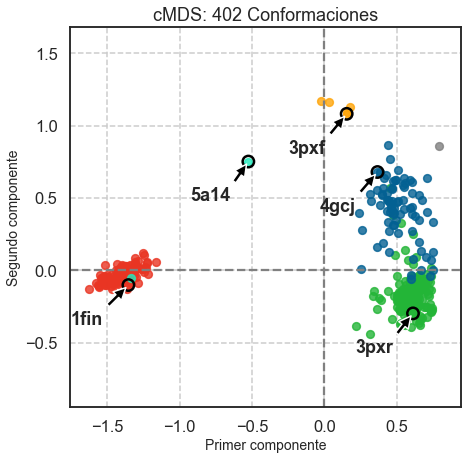

In [39]:
mds_plot = mds_pisani_402
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_plot[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), mds_plot[0][0], mds_plot[0][1], 
                      xytext_delta=[0.4, 0.3], s=130)

## Definimos dos funciones para procesar las trayectorias:

In [22]:
from sklearn.decomposition import PCA

def process_pca(traj, ref = 0,  n_vecs = 2):
    '''
    Performs PCA over a given trajectory
    Parameters:
        traj (pytraj.Trajectory): pytraj Trajectory object with sliced atoms
        ref (int): number of conformation inside traj to use as reference to superpose traj
        n_vects (int): Number of pca eigenvectors to return
    Returns:
        dict_pca: dictionary with
            pca (numpy array): n_vects eigenvectors
            variance (numpy array): explained variance of the n_vects eigenvectors
    '''
    # Copia el objeto traj a uno nuevo, pero sólo los átomos de mask
    traj_temp = traj.copy()
    traj_temp.superpose(ref = 0) # Superpone usando la  referencia indicada
    # Crea la matriz 2d de coordenadas por frame
    xyz_2d = traj_temp.xyz.reshape(traj_temp.n_frames, traj_temp.n_atoms * 3)
    # Realiza el PCA
    pca = PCA(n_components = n_vecs)
    components = pca.fit_transform(xyz_2d)
    dict_pca = {'pca': components, 'variance': pca.explained_variance_ratio_ * 100}
    return(dict_pca)

In [37]:
from modules.MDS import cMDS_proj
def get_sup_points_projected_mds(MDS_ref_object, traj_reference, 
                                 traj_out_of_sample, ref = 0, n_components = 2):
    '''
    Obtain the D-suplementary RMSD matrix of a suplementary trajectory and 
    perfroms cMDS projection of out of sample points by using get_sup_rmsd_pairwise() function.
    
    Parameters:
        MDS_ref_object (MDS object): cMDS object.
        traj_reference (pytraj.trajectory): pytraj Trajectory object with m frames and sliced atoms
        traj_out_of_sample: pytraj Trajectory object with n frames sliced atoms
        ref (int):  number of conformation inside traj_reference to use 
                    as reference to superpose traj_out_of_sample
        n_vects (int): Number of mds eigenvectors to return
    Returs:
        mds_projected (numpy narray): n_vects mds eigenvectors
    '''
    # Se generan copias temporales de los objetos
    full_traj = traj_reference.copy()
    sup_traj = traj_out_of_sample.copy()
    # Se obtiene el número de frames de cada trayectoria
    m_ref_frames = full_traj.n_frames
    n_sup_frames = sup_traj.n_frames
    # Ahora generamos una única trayectoria uniendo la referencia con la suplementaria
    full_traj.append_xyz(sup_traj.xyz)
    # Y superponemos al primer frame de referencia
    full_traj.superpose(ref = ref)
    # Ahora full_traj tiene m+n frames
    m_plus_n_frames = full_traj.n_frames
    # Se genera la matriz suplementaria m conf referencia por n confs suplementarias
    mtx_rmsd_sup = np.empty((m_ref_frames, n_sup_frames))
    
    for i in range(m_ref_frames):
        # Se calcula el RMSD de cada frame i de la traj de referencia vs la traj suplementaria
        rmsd = pyt.rmsd(traj= full_traj, ref = i, 
                        nofit=True, 
                        # Sólo calcula el rmsd para los sup_frames
                        frame_indices = range(m_ref_frames, m_plus_n_frames))
        mtx_rmsd_sup[i] = rmsd
    # m * n matrix with RMSD values of  traj_out_of_sample frames againts traj_reference frames.
    # Performs th projection
    mds_projected = cMDS_proj(MDS_ref_object, mtx_rmsd_sup.T)
    
    return( mds_projected[: , 0 : n_components].T )

In [35]:
traj_crystals[100:300]

pytraj.Trajectory, 200 frames: 
Size: 0.000523 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, non-PBC>
           

In [165]:
projection_example = \
        get_sup_points_projected_mds(MDS_ref_object = mds_pisani_402, 
              traj_reference = traj_crystals, 
              # Las consf de prueba son un subconjunto de las de referencia
              traj_out_of_sample = traj_crystals[::2], 
              ref = 0, n_components = 2)

### Visualizamos la proyección de los mismo puntos

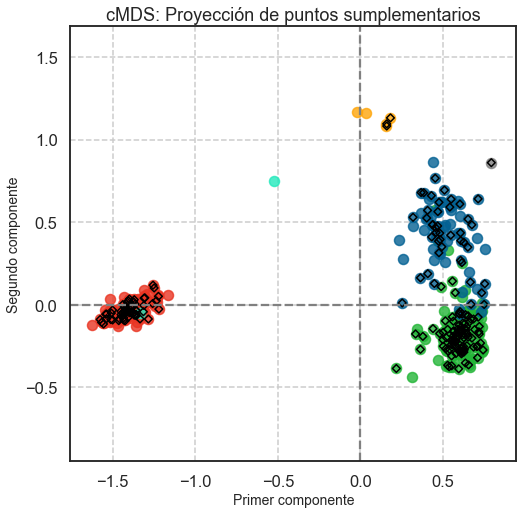

In [166]:
# Se genera la gráfica de ejmplo de proyección
fig = plt.figure(figsize=(8, 8))
plot_points(mds = mds_pisani_402[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: Proyección de puntos sumplementarios", point_size = 100)
# Proyección de los puntos "out of sample"
plt.scatter(projection_example[0], projection_example[1], marker = 'D', 
            c = 'None', edgecolors='black', s = 30);

<p class="p-5 border bg-success font-weight-bold">Los puntos suplementarios son proyectados correctamente.</p>

# Comenzamos el análisis de una trayectoria

## Proteína CDK2: 4fku
**Conformación apo -  SA/Solventes mixtos**

Definimos el directorio de las dinámicas.

In [21]:
DM_DIR =  os.path.join('..', '..', 'ARCHIVOS', 'DINAMICA')

### Carga de la trayectoria
**Path de los archivos:**

In [81]:
system = '4fku'
md_type = 'mxs_sa'
file_basename = 'mxs_cdk2'
# Definimos el path del archivo prmtop y del rst7, el rst7 funciona como la conforamción de
# refeencia al ser la conformación cristalográfica
ref_conf_4fku_path_rst7 = \
    os.path.join(DM_DIR, system, md_type, 'rep_1', F'{file_basename}.rst7')
ref_conf_4fku_path_prmtop = \
    os.path.join(DM_DIR, system, md_type, 'rep_1', F'{file_basename}.prmtop')

# Ahora definimos los paths de minimización, SA, equilibrado y producción
# minimización, sólo se guardó un rst7
min_conf_4fku = \
    os.path.join(DM_DIR, system, md_type, 'rep_1', '1_min', F'{file_basename}_min_all.rst7')

# SA, Eq y Producción
sa_traj_4fku, eq_traj_4fku, prod_traj_4fku = \
    glob.glob(os.path.join(DM_DIR, system, md_type, 'rep_1', '*/', F'{file_basename}*.nc'))

# Lista de archivos
traj_list_4fku_paths = [ref_conf_4fku_path_rst7, min_conf_4fku, sa_traj_4fku, eq_traj_4fku, prod_traj_4fku]

print('La trayectoria será cargada en este orden:')
for i in traj_list_4fku_paths:
    print(i)

La trayectoria será cargada en este orden:
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_1/mxs_cdk2.rst7
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_1/1_min/mxs_cdk2_min_all.rst7
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_1/2_term/mxs_cdk2_term.nc
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_1/3_eq/mxs_cdk2_eq.nc
../../ARCHIVOS/DINAMICA/4fku/mxs_sa/rep_1/4_prod/mxs_cdk2_prod.nc


Con los archivos definidos arriba, usamos pytraj.iterload() para cargar todas las conformaciones:
1. **Referencia (rst7):** 1 frame, archivo de cordenadas iniciales.
- **Minimización (rst7):** 1 frame, archivo de coordanadas tras minimización con solvente explícito.
- **Simulate Annealing/Termalización:** 300 frames, trayectoria de 3 ns (a 1 fs/paso) del calentamiento/SA.
- **Equilibrado:** 250 frames,trayectoria de 5 ns (2 ns/paso( del equilibrado.
- **Producción:** 1000 frames, trayectoria de producción de 20 ns (2 ns/paso).

In [227]:
trajs_iterator_4fku = pyt.iterload(traj_list_4fku_paths, top = ref_conf_4fku_path_prmtop)
trajs_iterator_4fku

pytraj.TrajectoryIterator, 1552 frames: 
Size: 1.471476 (GB)
<Topology: 42418 atoms, 11334 residues, 11037 mols, PBC with box type = truncoct>
           

Podemos contabilizar el número de frames:
> Para ello leemos las trayectorias por fase de forma independiente.  
No usamos pyt.load() para no cargar las trayectorias en memoria, sólo nos interesa saber el número de frames.

In [249]:
list_by_phase = [pyt.iterload(traj, top = ref_conf_4fku_path_prmtop) for traj in traj_list_4fku_paths]
list_name_phases = ['crys', 'min', 'sa', 'eq', 'prod']
dic_n_frames_by_phase = \
    {list_name_phases[i] : traj.n_frames for i, traj in enumerate(list_by_phase)}

for i, j in dic_n_frames_by_phase.items():
    print(F'{i.upper()}: \t{j} frames')

CRYS: 	1 frames
MIN: 	1 frames
SA: 	300 frames
EQ: 	250 frames
PROD: 	1000 frames


Aplicamos la máscara de Pisani y nos quedamos sólo con los CA de su lista de residuos. Esto a su vez convierte el objeto pytraj.Trajectoryiterator() a pytraj.Trajectory().

In [266]:
traj_full_4fku = trajs_iterator_4fku[mask_pisani]
traj_full_4fku

pytraj.Trajectory, 1552 frames: 
Size: 0.004059 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, PBC with box type = truncoct>
           

## Proyección de la trayectoria

In [267]:
full_traj_4fku_projection = \
        get_sup_points_projected_mds(MDS_ref_object = mds_pisani_402, 
              traj_reference = traj_crystals, 
              # Las consf de prueba son un subconjunto de las de referencia
              traj_out_of_sample = traj_full_4fku, 
              ref = 0, n_components = 2)

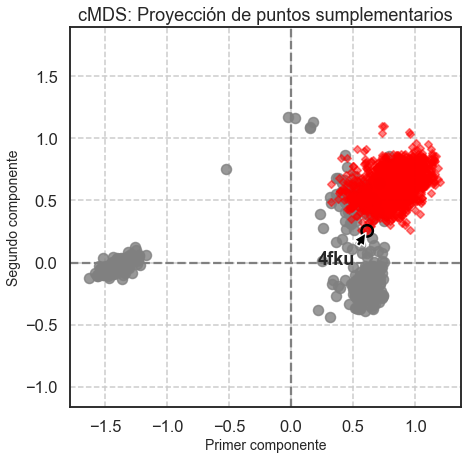

In [268]:
# Se genera la gráfica de la proyección
fig = plt.figure(figsize=(7, 7))
plot_points(mds = mds_pisani_402[0], colors_list = ['grey'], alpha = 0.8,
            title = "cMDS: Proyección de puntos sumplementarios", point_size = 100)
# Proyección de los puntos "out of sample"
plt.scatter(full_traj_4fku_projection[0], full_traj_4fku_projection[1], marker = 'D', 
            c = 'red', s = 30, alpha = 0.5)
plot_anotation_labels(list_of_all_index = df_prot.index,  list_of_ref_names = ['4fku'], 
                      x = mds_pisani_402[0][0], y = mds_pisani_402[0][1], 
                      xytext_delta=[0.4, 0.3], s=130);

## Visualización con bokeh

Cargamos las librerías necesarias para bokeh.

In [379]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import Span, HoverTool
from bokeh.transform import factor_cmap

### Paletas de colores
Creamos las paletas de colores para representar cada fase de las trayectorias.

In [442]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from collections import OrderedDict

# SA: De amarillo a Rojo
cmap_sa = cm.get_cmap('autumn', dic_n_frames_by_phase['sa'])
colors_sa = np.array([rgb2hex(cmap_sa(i)[:3]) for i in range(cmap_sa.N)])
# Eq: de azules
cmap_eq = cm.get_cmap('winter', dic_n_frames_by_phase['eq'])
colors_eq = np.array([rgb2hex(cmap_eq(i)[:3]) for i in range(cmap_eq.N)])
# Prod: violeta
cmap_prod = cm.get_cmap('Purples', dic_n_frames_by_phase['crys'])
colors_prod = np.array([rgb2hex(cmap_prod(i)[:3]) for i in range(cmap_prod.N)])
colors_prod

array(['#3f007d'], dtype='<U7')

In [ ]:
# Datasource referencia
conf_labels = conformation_labels.unique()
mds_total = mds_pisani_402
source_mds_ref = ColumnDataSource(data = dict(
    x = mds_total[0][0],
    y = mds_total[0][1],
    pdb_id = df_prot.index.to_series().apply(lambda x: x.upper()),
    conf_label = conformation_labels,
    color_labels = color_labels,
))

In [554]:
# Dataframe con los datos de los puntos proyectados
color_maps = ['Purples', 'Blues', 'autumn', 'cool', 'winter']

labels_traj_by_phase = []
colors_phases = []
for n, label, color in zip(dic_n_frames_by_phase.values(), dic_n_frames_by_phase.keys(), color_maps):
    labels_traj_by_phase = labels_traj_by_phase + [*np.repeat(label, n)]
    cmap = cm.get_cmap(color, n)
    colors_phases = colors_phases + [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
# Se crea el dataframe
df_source_mds_proj = pd.DataFrame(dict(
                    x = full_traj_4fku_projection[0],
                    y = full_traj_4fku_projection[1],
                    md_phase = np.array(labels_traj_by_phase),
                    phase_colors = colors_phases
                ))


In [555]:
# Se crean los datasources de proyección
dic_datasources_proj = {key : df_source_mds_proj[df_source_mds_proj.md_phase == key]
                        for key in dic_n_frames_by_phase.keys()}

### Generamos el plot

In [559]:
# Hover sólo para conformaciones de referencia
HOVER = HoverTool(names=["ref"])
TOOLS = ['pan', 'wheel_zoom', HOVER]
TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("PDB ID", "@pdb_id"),
    ("conf", "@conf_label"),
]
# Definición del plot
p = figure(tools=TOOLS, active_scroll='wheel_zoom', 
           match_aspect = True, plot_width = 950, 
           tooltips = TOOLTIPS,  title = "cMDS: 402 Conformaciones - Proyección",
           x_axis_label = 'Dimensión 1', y_axis_label = 'Dimensión 2')

# Proyección de los puntos de referencia
p.scatter('x','y', source = source_mds_ref, name = 'ref',
          size = 12,
          fill_color='grey', fill_alpha=0.8,
          line_color=None)

from bokeh.models import ColorBar
from bokeh.transform import  LinearColorMapper
# Proyección de las conformaciones de la trayectoria
for source_phase in dic_datasources_proj.values():
    p.scatter('x','y', source = source_phase,
              size = 10, marker = 'diamond',
              fill_color= 'phase_colors',
              fill_alpha=1, legend = 'md_phase',
              line_color=None)
    x = source_phase.phase_colors
    if len(x) > 1:
        mapper = LinearColorMapper(palette = x, low=0, high= len(x))
        color_bar = ColorBar(color_mapper=mapper, width=8,  location=(0,0))
        p.add_layout(color_bar, 'right')

# Vertical line
vline = Span(location=0, dimension='height', line_color='grey', line_width=3, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', line_color='grey', line_width=3, line_dash='dashed')
p.renderers.extend([vline, hline])

In [561]:
output_notebook()
show(p)

Loading BokehJS ...

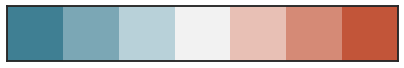

In [486]:
sns.palplot(sns.diverging_palette(220, 20, n=7))

In [275]:
a = np.array([1, 2, 3, 4])
a[:-2]

array([1, 2])

**Minimización**

In [ ]:
min_traj_4fku_path = glob.glob(
    os.path.join(DM_DIR, system, md_type, 'rep_1', '1_min', F'{file_basename}.rst7'))[0]
sa_traj_4fku_path = glob.glob(
    os.path.join(DM_DIR, system, md_type, 'rep_1', F'{file_basename}.rst7'))[0]

ninguna de las funciones de procesamiento aplican ninguna máscara, con lo cual, las trayectorias de entrada con ñas que trabajan deben tener sólo los átomos con los que se quiere trabajar, y éstas deben tener el mismo número de átomos para la conformación de referencia, la trayectoria de referencia, y las trayectorias a procesar.

In [226]:
[pyt.iterload(traj, prmtop_files[0]) for traj in nc_files]

In [225]:
s[:, 0:2 ].T.shape

(2, 402)

In [224]:
mds_total[0].shape

(362, 402)

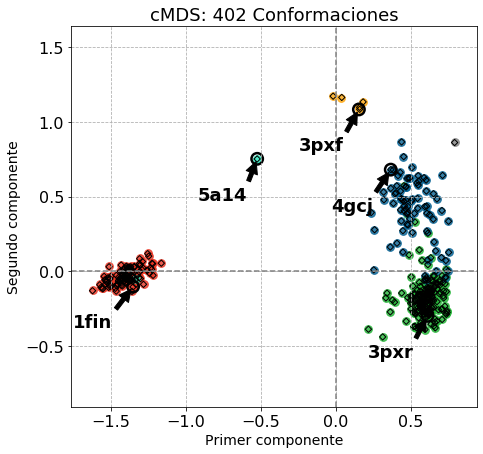

In [220]:
# Prueba de get_sup_rmsd_pairwise con los cristales
from modules.MDS import cMDS_proj
D_sup = get_sup_rmsd_pairwise(traj_crystals, traj_crystals[:])

s = cMDS_proj(mds_total, D_sup)

ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")

plt.scatter(s[:, :2].T[0], s[:, 1], marker = 'D', c = 'None', edgecolors='black', s = 20)
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

In [231]:
def process_trajectory(system, md_type, file_basename, mask, 
                       obj_mds, traj_reference,
                       prod_dir = '4_prod', system_dir = DM_DIR):
    # OJO: La máscara debe ser aplicada una sola vez

    # Carga de la estructura de referencia, se extrae por default de la rep_1
    sytem_path = os.path.join(system_dir, system, md_type)
    ref_rst7 = glob.glob(os.path.join(sytem_path, 'rep_1', F'{file_basename}.rst7'))[0]
    ref_prmtop = glob.glob(os.path.join(sytem_path, 'rep_1', F'{file_basename}.prmtop'))[0]
    ref_conf = pyt.load(filename = ref_rst7, top = ref_prmtop,
                        # Seleccionamos únicamente la proteína
                         mask = mask)
    
    # Generamos el path de las conformaciones
    # Cargamos todas las trayectorias en  orden alfanumérico
    prmtop_files = sorted(glob.glob(os.path.join(sytem_path, 
                                             'rep_*', prod_dir, 'CA*prmtop')))
    nc_files = sorted(glob.glob(os.path.join(sytem_path, 
                                             'rep_*', prod_dir, 'CA*_prod.nc')))
    print(ref_conf)
    
    # Lista de trayectorias
    traj_list = [pyt.iterload(traj, prmtop_files[0]) for traj in nc_files]
    # En este punto a las trayectorias no se le han aplicado la máscara
    
    # Diccionario de trayectorias
    # Todas son superpuestas a la conformación inicial, y se aplica la máscara
    dic_trajs = {F'rep_{i+1}': 
                 traj_list[i][mask].superpose(ref = ref_conf)
                 for i in range (len(traj_list))}
    print(traj_list)
    
    # Cálculo del Rmsd por replica, almacenado en un dataFrame
    pd_rmsd = pd.DataFrame({key: pyt.rmsd(traj, 
                    ref = ref_conf) 
                    for key, traj in dic_trajs.items()})
    
    # Se obtienen los PCA independientes (por replica) usando sklearn
    # Los pca independientes no tienen superposición con el frame inicial
    dic_pca_traj = {key: process_pca(traj, ref = 0, n_vecs = 2) 
                for key, traj in dic_trajs.items()}
    
    # Se crea una trayectoria única, tomando como conformación inicial
    # la conformación de referencia
    full_traj = ref_conf.copy()
    
    for traj in traj_list:
        # Se plica la máscara porque en cada traj de traj_list no se había aplicado
        full_traj.append_xyz(traj[mask].xyz) 
    
    # PCA total
    pca = process_pca(full_traj, ref = 0,  n_vecs = 2)
    
    # MDS proyección a un espacio de REFERENCIA por trayectoria
    # 1) Se obtiene la  matriz suplementaria para cada traj
    dic_mds_sup_projections = {key: 
                               get_projected_points_mds(obj_mds, traj_reference = traj_reference,
                                                     traj_out_of_sample = traj) 
                for key, traj in dic_trajs.items()}
    
    return(dic_mds_sup_projections)

In [232]:
%%time
a = process_trajectory(system = '4fku', md_type = 'mix_solv', 
                       file_basename = 'mxs_cdk2', mask = mask_pisani,
                      obj_mds = mds_total, traj_reference= traj_crystals)
a

pytraj.Trajectory, 1 frames: 
Size: 0.000003 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, PBC with box type = truncoct>
           
[pytraj.TrajectoryIterator, 1000 frames: 
Size: 0.006661 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           , pytraj.TrajectoryIterator, 1000 frames: 
Size: 0.006661 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           , pytraj.TrajectoryIterator, 1000 frames: 
Size: 0.006661 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           , pytraj.TrajectoryIterator, 1000 frames: 
Size: 0.006661 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           , pytraj.TrajectoryIterator, 1000 frames: 
Size: 0.006661 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           ]
pytraj.Trajectory, 5001 frames: 
Size: 0.013078 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, PBC with box

{'rep_1': array([[0.78239021, 0.76936897, 0.85406565, ..., 0.78565745, 0.74160117,
         0.75656394],
        [0.1304588 , 0.03408631, 0.06249055, ..., 0.22217417, 0.27356883,
         0.17262225]]),
 'rep_2': array([[0.98595173, 0.90313077, 0.97050574, ..., 1.28625538, 1.26959083,
         1.18374901],
        [0.74537705, 0.80225276, 0.78816496, ..., 0.63146567, 0.62141426,
         0.68303913]]),
 'rep_3': array([[ 1.18131404,  1.08604152,  1.09971088, ...,  1.07943524,
          1.1216803 ,  1.04088174],
        [ 0.02812346, -0.00527517, -0.00488579, ...,  0.05714845,
          0.08793711,  0.07776327]]),
 'rep_4': array([[0.78239021, 0.76936897, 0.85406565, ..., 0.78565745, 0.74160117,
         0.75656394],
        [0.1304588 , 0.03408631, 0.06249055, ..., 0.22217417, 0.27356883,
         0.17262225]]),
 'rep_5': array([[-3.75646302e-01, -3.26862528e-01, -1.76371028e-01, ...,
          2.79827645e-01,  2.55163788e-01,  3.35447564e-01],
        [-2.70031407e-05, -1.36945480e-01

In [233]:
a['rep_1']

array([[0.78239021, 0.76936897, 0.85406565, ..., 0.78565745, 0.74160117,
        0.75656394],
       [0.1304588 , 0.03408631, 0.06249055, ..., 0.22217417, 0.27356883,
        0.17262225]])

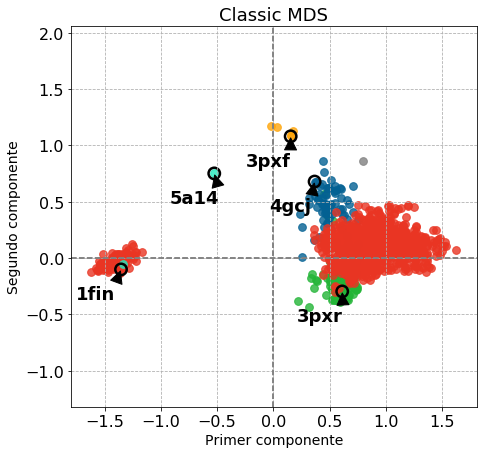

In [242]:
# Prueba de get_sup_rmsd_pairwise con los cristalesNew
from modules.MDS import cMDS_proj
D_sup = get_sup_rmsd_pairwise(traj_crystals, traj_crystals[:])

s = cMDS_proj(mds_total, D_sup)

ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange"}
# Se genera la gráfica
fig = plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: 402 Conformaciones")
plot_points(mds = a['rep_1'], alpha=0.8)
plot_anotation_labels(df_prot.index,  ref_structs_dict.keys(), 
                      mds_total[0][0], mds_total[0][1], xytext_delta=[0.4, 0.3], s=130)

In [249]:
len(a['pcs'][0])

207

In [8]:
# Primer sitema a evaluar
path_4fku_mxs_plain = os.path.join(DM_DIR, '4fku', 'mix_solv')
mask = F"(:{pisiani_residues})&(@CA)"
ref_conf = ref_conf_4fku

# Cargamos todas las trayectorias
prmtop_files = sorted(glob.glob(os.path.join(path_4fku_mxs_plain, 'rep_*', '4_prod', 'PROT*prmtop')))
nc_files = sorted(glob.glob(os.path.join(path_4fku_mxs_plain, 'rep_*', '4_prod', 'PROT*_prod.nc')))

# Lista de trayectorias
traj_list = [pyt.iterload(i, prmtop_files[0]) for i in nc_files]

# Diccionario de trayectorias
dic_trajs = {F'rep_{i+1}': traj_list[i].superpose(ref = ref_conf, 
                                                mask = mask)
             for i in range (len(traj_list))}
# Cálculo del Rmsd por replica
dic_rmsd = {key: pyt.rmsd(traj, ref = ref_conf,  mask = mask) 
                for key, traj in dic_trajs.items()}
# Se obtienen los PCA independientes (por replica)
dic_pca_traj = {key: pyt.pca(traj, mask = mask, n_vecs = 2) 
                for key, traj in dic_trajs.items()}

# Se crea una trayectoria única
# Creamos una tryectoria unica
full_traj = ref_conf_4fku.copy()
for traj in traj_list:
    full_traj.append_xyz(traj.xyz)
# Superposición hacia el frame de referencia
full_traj.superpose(ref = ref_conf, mask = mask)

# pca
pca = pyt.pca(full_traj, mask = mask)

# Cálculo de la amtriz de rmsd
distances = pyt.pairwise_rmsd(full_traj, mask = mask)

# Clustering Jerárquico

NameError: name 'ref_conf_4fku' is not defined

In [142]:
import matplotlib.pyplot as plt
from modules.plotting_functions import plot_points, plot_anotation_labels
import seaborn as sns
import pylab
sns.set(context = 'talk', style = 'ticks')

In [262]:
a['pca'][:,0]

array([2.35885668, 1.62599013, 1.92049923, ..., 6.50373271, 6.1863327 ,
       6.43226069])

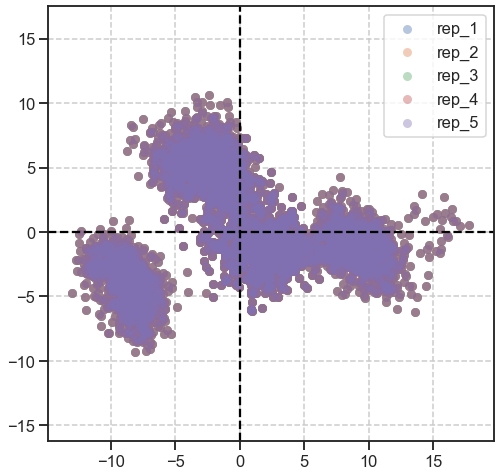

In [263]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = a['pca'][:,0], 
                    y = a['pca'][:,1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal');


In [396]:
pca = pyt.pca(full_traj, mask = mask)

In [390]:
pca.explained_variance_ratio_*100

array([3.94252889e+01, 1.26800556e+01, 7.55065637e+00, ...,
       1.19200604e-27, 9.49503722e-29, 4.65128868e-29])

In [379]:
[i/sum(pca[1][0]) for i in pca[1][0]]

[0.39425265930899556,
 0.12680076033878776,
 0.07550664411264875,
 0.06908891324488467,
 0.03466443189619723,
 0.03160990625297929,
 0.030067984589310294,
 0.022547693784029623,
 0.017873003359961143,
 0.014966703512153559,
 0.013346918679501038,
 0.010736474638853168,
 0.009395910337658433,
 0.008342413040989127,
 0.00708194095690249,
 0.006656499483769929,
 0.0061194657494844625,
 0.005993647370472647,
 0.005051034694726115,
 0.004430925343464343,
 0.004209757087690164,
 0.0037942545946620283,
 0.003445194182361782,
 0.0032951070197558656,
 0.0030360393588826115,
 0.0029248121698563154,
 0.002896282151467352,
 0.0025750667147247715,
 0.002390131676656613,
 0.00227171790835527,
 0.002159812761178698,
 0.002045291363875083,
 0.0019507710380235845,
 0.0018164305524390946,
 0.0017604720052345375,
 0.001663816753631227,
 0.0015834939220702078,
 0.0015336751273958382,
 0.0015183999939709697,
 0.0014802439529648778,
 0.0014392431820909922,
 0.0013224497485699758,
 0.0012831738123432372,
 0.

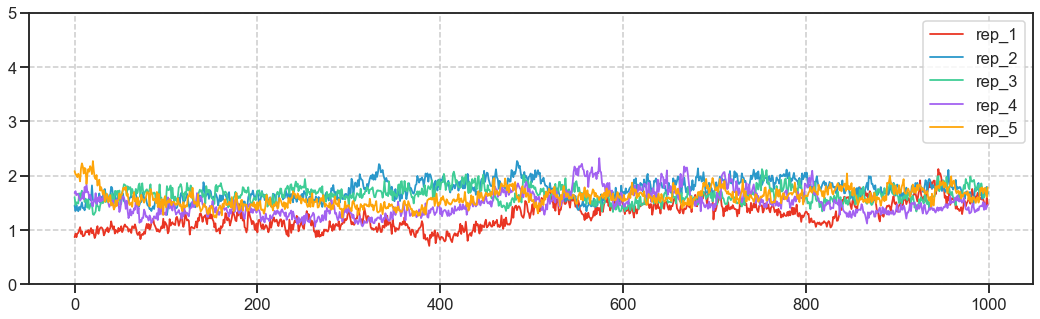

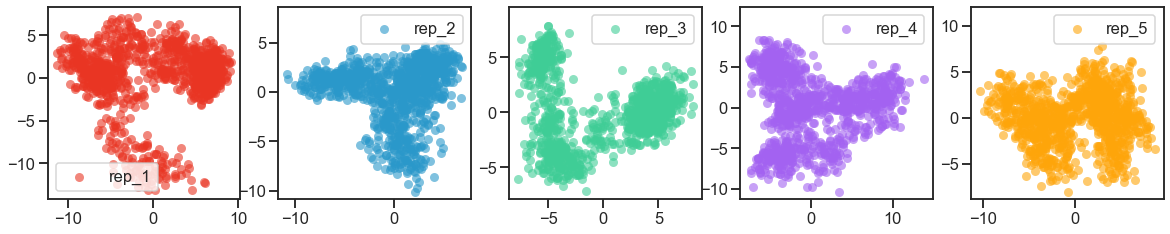

In [336]:
# Gráfica de los RMSD
fig = plt.figure(figsize=(18, 5))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
counter = 0
for key, rmsd in dic_rmsd.items():
    sns.lineplot(x = range(len(rmsd)), y = rmsd, label = key, 
                 linewidth = 1.8, color = colors_list[counter])
    counter += 1
plt.ylim(bottom = 0, top = 5)
plt.grid(linestyle='--')

# Plots de PCA
fig, ax = plt.subplots(figsize=(20, 5))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
for i in range(1, 6):
    plt.subplot(1, 5, i)
    data = dic_pca_traj[F'rep_{i}'][0]
    ax = sns.scatterplot(x = data[0], y = data[1], 
                         alpha=0.6, label = F'rep_{i}',
                         linewidth=0, color = colors_list[i-1])
    plt.axis('square');

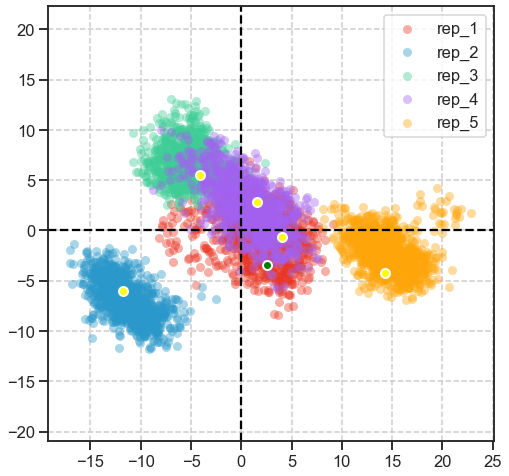

In [397]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0, color = colors_list[i])
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'green', linewidth=2)
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 1, linewidth=2)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal');


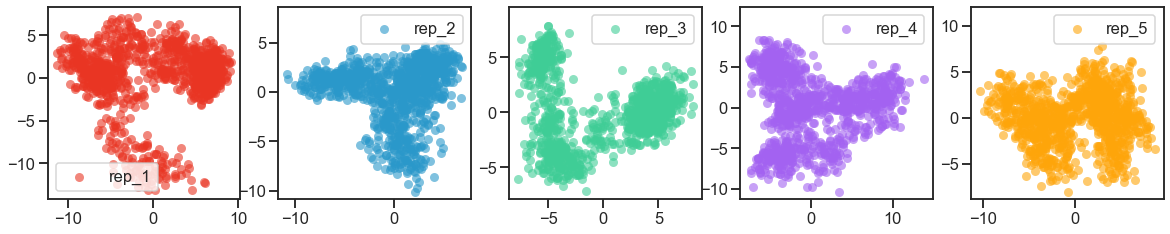

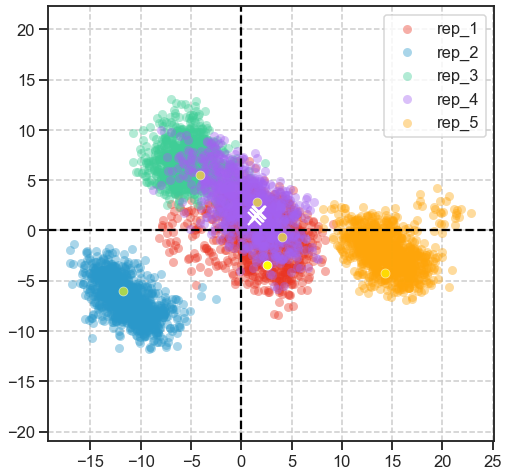

In [398]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0, color = colors_list[i])
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.grid(linestyle='--')
plt.axis('equal');


In [94]:
full_traj.superpose(ref = ref_conf_4fku, mask = F"(:{pisiani_residues})&(@CA)")

pytraj.Trajectory, 5001 frames: 
Size: 0.541915 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, PBC with box type = ortho>
           

In [99]:
# pca
pca = pyt.pca(full_traj, mask = F"(:{pisiani_residues})&(@CA)", n_vecs = 2) 

In [161]:
pca[0][1, 0]

3.4183853

(-19.2392757206234, 25.14126191037873, -14.497458990699151, 13.199858627146813)

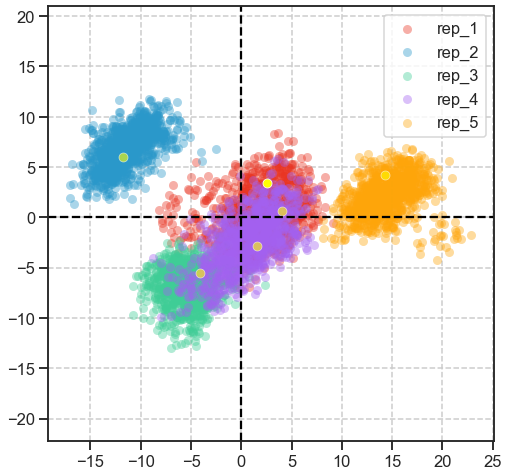

In [262]:
full_traj.superpose(ref = ref_conf_4fku, mask = F"(:{pisiani_residues})&(@CA)")
pca_pk = pyt.pca(full_traj, mask = F"(:{pocket_residues})&(@CA)", n_vecs = 2) 

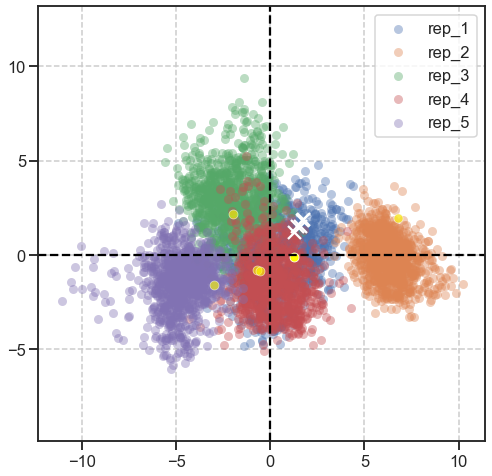

In [393]:
# pcoket
fig, ax = plt.subplots(figsize=(8, 8))
colores = ['Purples', 'Reds', 'Greens', 'Blues', 'Greys']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
for i in range(5):
    ax = sns.scatterplot(x = pca_pk[0][0, (i*1000)+1: ((i+1)*1000)+1], 
                    y = pca_pk[0][1, (i*1000)+1: ((i+1)*1000)+1],
                    alpha=0.4, label = F'rep_{i+1}', linewidth=0)
ax = sns.scatterplot(x = pca_pk[0][0, 0:1], y = pca_pk[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca_pk[0][0, cluster_data.centroids], 
                     y = pca_pk[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

In [226]:
# Clustering
import scipy
import scipy.cluster.hierarchy

# Cálculo de la amtriz de rmsd
distances = pyt.pairwise_rmsd(full_traj, mask = F"(:{pisiani_residues})&(@CA)")

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


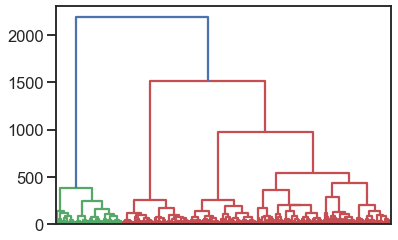

In [227]:
linkage = scipy.cluster.hierarchy.ward(distances)

scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')
None

In [254]:
# Clustering con sklearn
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(distances)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [341]:
sum(ward.labels_ == 3)
ward

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6,
                        pooling_func='deprecated')

In [345]:
%%time
# con kmeans de sklearn
from sklearn.cluster import KMeans
distances = pyt.pairwise_rmsd(full_traj, mask = F"(:{pisiani_residues})&(@CA)")
kmeans = KMeans(n_clusters=5).fit(distances)

CPU times: user 1min 8s, sys: 32.8 s, total: 1min 41s
Wall time: 49.6 s


In [401]:
centroids = kmeans.cluster_centers_
centroids[:, 0]

array([1.7367493, 1.4355682, 1.6012709, 1.2461708, 1.6776462],
      dtype=float32)

In [355]:
sum(kmeans.labels_ == 1)

916

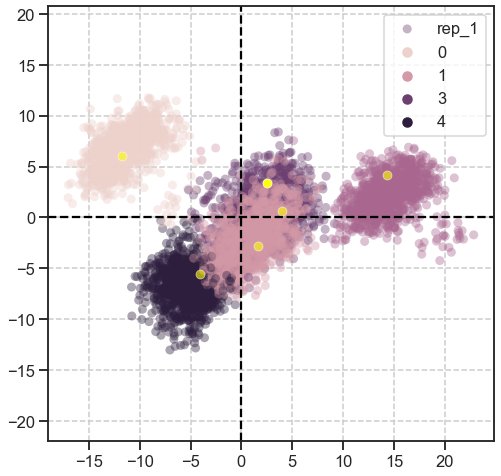

In [357]:
# Proyección única
fig, ax = plt.subplots(figsize=(8, 8))
colors_list = ['#E93523', '#2A98CA', '#3FCD96', '#A362F1', '#FEA50A']
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x = pca[0][0], 
                    y = pca[0][1], hue = kmeans.labels_,
                    alpha=0.4, label = F'rep_1', linewidth=0)
ax = sns.scatterplot(x = pca[0][0, 0:1], y = pca[0][1, 0:1], color = 'yellow')
ax = sns.scatterplot(x = pca[0][0, cluster_data.centroids], 
                     y = pca[0][1, cluster_data.centroids], color = 'yellow', alpha = 0.6)
plt.axhline(0, color='black',  linestyle='--')
plt.axvline(0, color='black',  linestyle='--')
plt.grid(linestyle='--')
plt.axis('equal');

In [342]:
%%time
# Clusterign con kmeans
cluster_data = pyt.cluster.kmeans(full_traj, mask = F"(:{pisiani_residues})&(@CA)", 
                                  n_clusters = 5)

CPU times: user 1min 40s, sys: 2.13 s, total: 1min 42s
Wall time: 1min 34s


In [343]:
cluster_data.cluster_index == 1

array([ True,  True,  True, ..., False, False, False])

In [344]:
cluster_data.centroids

array([2664,  272, 1593, 4551, 3406], dtype=int32)